<a href="https://colab.research.google.com/github/heko0826/HobbyColabProjects/blob/main/fcn_resnet50_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models.segmentation import fcn_resnet50

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
def get_dog_image():
  url = "https://dog.ceo/api/breeds/image/random"
  res = requests.get(url)
  if res.status_code == 200:
    data = res.json()
    image_url = data["message"]
    file = io.BytesIO(requests.get(str(image_url)).content)
    return file

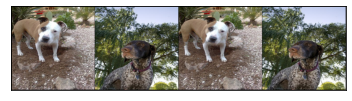

In [ ]:
transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])

dog1_int = Image.open(get_dog_image())
dog2_int = Image.open(get_dog_image())

dog1_int = transform(dog1_int)
dog2_int = transform(dog2_int)

grid = make_grid([dog1_int, dog2_int, dog1_int, dog2_int])
show(grid)

In [ ]:
batch_int = torch.stack([dog1_int, dog2_int])
batch = transforms.functional.convert_image_dtype(batch_int, dtype=torch.float)

model = fcn_resnet50(pretrained=True, progress=False)
model = model.eval()

normalized_batch = transforms.functional.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output = model(normalized_batch)["out"]
print(output.shape, output.min().item(), output.max().item())

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 21, 500, 500]) -6.077310085296631 13.897525787353516


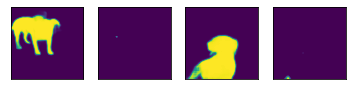

In [ ]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(batch.shape[0])
    for cls in ('dog', 'boat')
]

show(dog_and_boat_masks)